In [76]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [77]:
DATA_DIR = "."
# ============================================
# 1. Загрузка данных
# ============================================
# Погода (почасовые данные за несколько лет)
weather_files = sorted(glob.glob(f"{DATA_DIR}/weather_data_*.csv"))
weather_list = []
for fp in weather_files:
    df_w = pd.read_csv(fp)
    df_w['date'] = pd.to_datetime(df_w['date'], errors='coerce')
    weather_list.append(df_w)

weather = pd.concat(weather_list, ignore_index=True)
# Пожары
fires = pd.read_csv(f"{DATA_DIR}/fires.csv")
# Погрузки/выгрузки
supplies = pd.read_csv(f"{DATA_DIR}/supplies.csv")
# Температура штабелей
temps = pd.read_csv(f"{DATA_DIR}/temperature.csv")


In [78]:
fires['Дата составления'] = pd.to_datetime(fires['Дата составления'], errors='coerce')
fires['Дата начала'] = pd.to_datetime(fires['Дата начала'], errors='coerce')
fires['Дата оконч.'] = pd.to_datetime(fires['Дата оконч.'], errors='coerce')
fires['Нач.форм.штабеля'] = pd.to_datetime(fires['Нач.форм.штабеля'], errors='coerce')
print("fires.info():")
print(fires.info())
print("\nПропуски в fires:")
print(fires.isna().sum())

fires.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Дата составления  486 non-null    datetime64[ns]
 1   Груз              486 non-null    object        
 2   Вес по акту, тн   486 non-null    float64       
 3   Склад             486 non-null    int64         
 4   Дата начала       486 non-null    datetime64[ns]
 5   Дата оконч.       486 non-null    datetime64[ns]
 6   Нач.форм.штабеля  486 non-null    datetime64[ns]
 7   Штабель           486 non-null    int64         
dtypes: datetime64[ns](4), float64(1), int64(2), object(1)
memory usage: 30.5+ KB
None

Пропуски в fires:
Дата составления    0
Груз                0
Вес по акту, тн     0
Склад               0
Дата начала         0
Дата оконч.         0
Нач.форм.штабеля    0
Штабель             0
dtype: int64



Распределение дней до возгорания (до очистки):
count    486.000000
mean      94.483252
std       66.481766
min     -284.125000
25%       50.538542
50%       86.146528
75%      119.797222
max      666.875000
Name: Дней до возгорания, dtype: float64


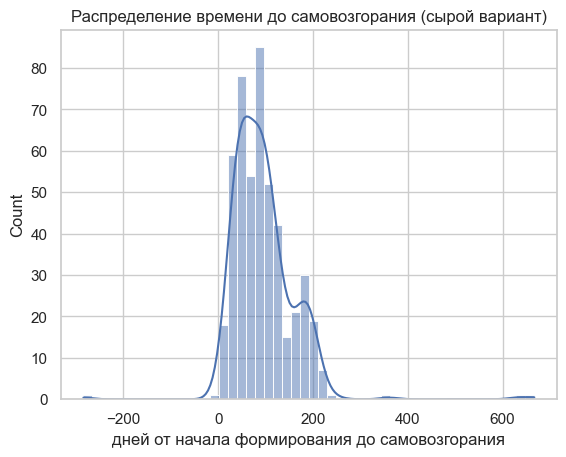

In [79]:
fires['Дней до возгорания'] = (fires['Дата начала'] - fires['Нач.форм.штабеля']).dt.total_seconds() / 86400
print("\nРаспределение дней до возгорания (до очистки):")
print(fires['Дней до возгорания'].describe())

plt.figure()
sns.histplot(fires['Дней до возгорания'], bins=50, kde=True)
plt.title("Распределение времени до самовозгорания (сырой вариант)")
plt.xlabel("дней от начала формирования до самовозгорания")
plt.show()

In [80]:
fires_clean = fires[(fires['Дней до возгорания'] >= 0) & fires['Дней до возгорания'].notna()].copy()
print("После удаления отрицательных/NaN:")
print(fires_clean['Дней до возгорания'].describe())

print("Кол-во пожаров по складам:")
print(fires_clean['Склад'].value_counts())

print("Кол-во пожаров по грузу:")
print(fires_clean['Груз'].value_counts())


После удаления отрицательных/NaN:
count    484.000000
mean      95.467012
std       64.192550
min        6.375000
25%       50.672396
50%       86.552431
75%      119.875000
max      666.875000
Name: Дней до возгорания, dtype: float64
Кол-во пожаров по складам:
Склад
6    199
4    184
3    101
Name: count, dtype: int64
Кол-во пожаров по грузу:
Груз
A1    482
B2      1
E5      1
Name: count, dtype: int64


In [81]:
supplies['ВыгрузкаНаСклад'] = pd.to_datetime(supplies['ВыгрузкаНаСклад'], errors='coerce')
supplies['ПогрузкаНаСудно'] = pd.to_datetime(supplies['ПогрузкаНаСудно'], errors='coerce')

print("\nSupplies:")
print(supplies.info())
print("\nПропуски в supplies:")
print(supplies.isna().sum())

print("Описательная статистика по массам в supplies:")
print(supplies[['На склад, тн','На судно, тн']].describe())



Supplies:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6323 entries, 0 to 6322
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ВыгрузкаНаСклад  6323 non-null   datetime64[ns]
 1   Наим. ЕТСНГ      6323 non-null   object        
 2   Штабель          6323 non-null   int64         
 3   ПогрузкаНаСудно  6323 non-null   datetime64[ns]
 4   На склад, тн     6323 non-null   float64       
 5   На судно, тн     6321 non-null   float64       
 6   Склад            6323 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 345.9+ KB
None

Пропуски в supplies:
ВыгрузкаНаСклад    0
Наим. ЕТСНГ        0
Штабель            0
ПогрузкаНаСудно    0
На склад, тн       0
На судно, тн       2
Склад              0
dtype: int64
Описательная статистика по массам в supplies:
        На склад, тн   На судно, тн
count    6323.000000    6321.000000
mean     9892.6761

In [82]:
supplies_clean = supplies[(supplies['На склад, тн'] > 0) & (supplies['На судно, тн'] > 0) & supplies['На судно, тн'].notna() & supplies['На склад, тн'].notna()]
print("После удаления отрицательных/NaN:")
print(supplies[['На склад, тн','На судно, тн']].describe())

После удаления отрицательных/NaN:
        На склад, тн   На судно, тн
count    6323.000000    6321.000000
mean     9892.676121    9879.046767
std     12689.089027   12681.216619
min       149.804000       0.119000
25%       736.992500     720.443000
50%      5474.994500    5436.676500
75%     13713.067000   13705.323500
max    120700.170000  120700.170000


In [83]:
temps['Дата акта'] = pd.to_datetime(temps['Дата акта'], errors='coerce')
print("Temps info:")
print(temps.info())
print("Пропуски в temps:")
print(temps.isna().sum())

Temps info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106 entries, 0 to 4105
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Склад                     4106 non-null   int64         
 1   Штабель                   4106 non-null   int64         
 2   Марка                     4106 non-null   object        
 3   Максимальная температура  4106 non-null   float64       
 4   Пикет                     3647 non-null   object        
 5   Дата акта                 4106 non-null   datetime64[ns]
 6   Смена                     3949 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 224.7+ KB
None
Пропуски в temps:
Склад                         0
Штабель                       0
Марка                         0
Максимальная температура      0
Пикет                       459
Дата акта                     0
Смена                     

In [84]:
print("\nДиапазон дат температурных актов:", temps['Дата акта'].min(), "–", temps['Дата акта'].max())
print("\nОписательная статистика по максимуму температуры:")
print(temps['Максимальная температура'].describe())


Диапазон дат температурных актов: 2019-11-23 00:00:00 – 2020-09-30 00:00:00

Описательная статистика по максимуму температуры:
count    4106.000000
mean       44.563809
std        49.552172
min         0.000000
25%        27.100000
50%        33.900000
75%        38.900000
max       679.000000
Name: Максимальная температура, dtype: float64


Weather:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61344 entries, 0 to 61343
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           61344 non-null  datetime64[ns]
 1   t              61344 non-null  float64       
 2   p              61344 non-null  float64       
 3   humidity       61344 non-null  int64         
 4   precipitation  61344 non-null  float64       
 5   wind_dir       61344 non-null  int64         
 6   v_avg          61344 non-null  float64       
 7   v_max          61344 non-null  float64       
 8   cloudcover     61344 non-null  int64         
 9   visibility     0 non-null      float64       
 10  weather_code   61344 non-null  int64         
dtypes: datetime64[ns](1), float64(6), int64(4)
memory usage: 5.1 MB
None
Диапазон дат погоды: 2015-01-01 00:00:00 – 2021-12-31 23:00:00
Пропуски в weather:
date                 0
t                    0
p               

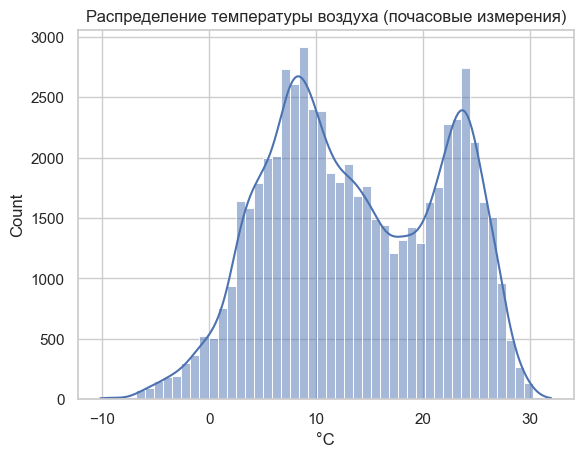

In [85]:
print("Weather:")
print(weather.info())
print("Диапазон дат погоды:", weather['date'].min(), "–", weather['date'].max())
print("Пропуски в weather:")
print(weather.isna().sum())

plt.figure()
sns.histplot(weather['t'], bins=50, kde=True)
plt.title("Распределение температуры воздуха (почасовые измерения)")
plt.xlabel("°C")
plt.show()

In [86]:
weather = weather.drop(columns = 'visibility') # нет данных о видимости


In [87]:
# Делаем из почасовых данных дневные
weather_day = (weather.set_index('date').resample('D').agg({
        't': ['mean', 'max', 'min'],
        'humidity': 'mean',
        'precipitation': 'sum',
        'v_avg': 'mean',
        'v_max': 'max',
        'cloudcover': 'mean',
        'weather_code': 'max'
    })
)

weather_day.columns = ['_'.join(col).strip() for col in weather_day.columns.values]
print("Аггрегированные по дням погодные данные:")
print(weather_day.head())

Аггрегированные по дням погодные данные:
              t_mean  t_max  t_min  humidity_mean  precipitation_sum  \
date                                                                   
2015-01-01 -2.083333   -1.4   -2.7      72.958333                0.0   
2015-01-02  2.154167    6.7   -1.3      70.708333                0.0   
2015-01-03  5.750000    7.4    2.4      82.458333                2.4   
2015-01-04  5.141667    7.1    3.2      71.375000                3.1   
2015-01-05  3.333333    6.4    1.6      76.041667                6.1   

            v_avg_mean  v_max_max  cloudcover_mean  weather_code_max  
date                                                                  
2015-01-01   24.495833       54.0        70.625000               3.0  
2015-01-02   17.637500       35.3        47.791667               3.0  
2015-01-03   24.816667       46.8        89.750000              71.0  
2015-01-04   24.645833       46.8        73.375000              55.0  
2015-01-05   23.837500      

In [88]:
def weather_features_for_fire(row, window_days=30):
    """
    Для конкретного акта пожара берём последние window_days дней перед датой начала пожара
    и считаем средние/максимумы.
    """
    fire_date = row['Дата начала']
    
    # Берём период [fire_date - window_days, fire_date - 1]
    end = fire_date.normalize() - pd.Timedelta(days=1)
    start = end - pd.Timedelta(days=window_days-1)
    window = weather_day.loc[start:end]
    agg = window.mean()
    return pd.Series({f'weather_{c}': agg[c] for c in weather_day.columns})

In [89]:
def supply_features_for_fire(row):
    """
    Агрегируем данные по supplies для данного склада/штабеля
    с момента начала формирования до даты самовозгорания.
    """
    skl = row['Склад']
    stack = row['Штабель']
    start = row['Нач.форм.штабеля']
    fire_date = row['Дата начала']
    
    s = supplies.loc[(supplies['Склад'] == skl) &
        (supplies['Штабель'] == stack) &
        supplies['ВыгрузкаНаСклад'].between(start, fire_date, inclusive='both')]
    if s.empty:
        return pd.Series({
            'supply_total_count': 0,
            'supply_total_in': 0.0,
            'supply_total_out': 0.0,
            'supply_last_in_days_before_fire': np.nan
        })
    
    last_in_date = s['ВыгрузкаНаСклад'].max()
    days_before_fire = (fire_date - last_in_date).total_seconds() / 86400
    
    return pd.Series({
        'supply_total_count': len(s),
        'supply_total_in': s['На склад, тн'].sum(),
        'supply_total_out': s['На судно, тн'].sum(),
        'supply_last_in_days_before_fire': days_before_fire
    })

In [90]:
def build_temp_features_for_fire(row):
    """
    Агрегируем температурные измерения по данному складу/штабелю
    до момента пожара.
    """
    skl = row['Склад']
    stack = row['Штабель']
    fire_date = row['Дата начала']
    
    t = temps.loc[(temps['Склад'] == skl) &
        (temps['Штабель'] == stack) &
        (temps['Дата акта'] <= fire_date)].sort_values('Дата акта')
    if t.empty:
        return pd.Series({
            'temp_measurements_count': 0,
            'temp_max_before_fire': np.nan,
            'temp_mean_before_fire': np.nan,
            'temp_last_before_fire': np.nan,
            'temp_last_days_before_fire': np.nan
        })
    
    last_record = t.iloc[-1]
    days_before_fire = (fire_date - last_record['Дата акта']).total_seconds() / 86400
    
    return pd.Series({
        'temp_measurements_count': len(t),
        'temp_max_before_fire': t['Максимальная температура'].max(),
        'temp_mean_before_fire': t['Максимальная температура'].mean(),
        'temp_last_before_fire': last_record['Максимальная температура'],
        'temp_last_days_before_fire': days_before_fire
    })

In [98]:
weather_feats = fires_clean.copy().apply(weather_features_for_fire, axis=1)
supply_feats = fires_clean.copy().apply(supply_features_for_fire, axis=1)
temp_feats = fires_clean.copy().apply(build_temp_features_for_fire, axis=1)

df_model = pd.concat(
    [fires_clean.copy().reset_index(drop=True),
     weather_feats.reset_index(drop=True),
     supply_feats.reset_index(drop=True),
     temp_feats.reset_index(drop=True)], axis=1
)

df_model['stack_age_at_fire_days'] = df_model['Дней до возгорания']
df_model['fire_dayofyear'] = df_model['Дата начала'].dt.dayofyear
df_model['fire_month'] = df_model['Дата начала'].dt.month
df_model['fire_year'] = df_model['Дата начала'].dt.year

print("Размер итогового датафрейма для модели:", df_model.shape)
print("Столбцы:", df_model.columns.tolist())


Размер итогового датафрейма для модели: (484, 31)
Столбцы: ['Дата составления', 'Груз', 'Вес по акту, тн', 'Склад', 'Дата начала', 'Дата оконч.', 'Нач.форм.штабеля', 'Штабель', 'Дней до возгорания', 'weather_t_mean', 'weather_t_max', 'weather_t_min', 'weather_humidity_mean', 'weather_precipitation_sum', 'weather_v_avg_mean', 'weather_v_max_max', 'weather_cloudcover_mean', 'weather_weather_code_max', 'supply_total_count', 'supply_total_in', 'supply_total_out', 'supply_last_in_days_before_fire', 'temp_measurements_count', 'temp_max_before_fire', 'temp_mean_before_fire', 'temp_last_before_fire', 'temp_last_days_before_fire', 'stack_age_at_fire_days', 'fire_dayofyear', 'fire_month', 'fire_year']


In [92]:
target = 'Дней до возгорания'
cat_features = ['Груз', 'Склад', 'Штабель']
feature_cols = [
    c for c in df_model.columns
    if c not in [target, 'Дата составления', 'Дата начала', 'Дата оконч.', 'Нач.форм.штабеля']
]

X = df_model[feature_cols]
y = df_model[target]

num_features = [c for c in X.columns if c not in cat_features]

print("Числовые признаки:", num_features)
print("Категориальные признаки:", cat_features)

Числовые признаки: ['Вес по акту, тн', 'weather_t_mean', 'weather_t_max', 'weather_t_min', 'weather_humidity_mean', 'weather_precipitation_sum', 'weather_v_avg_mean', 'weather_v_max_max', 'weather_cloudcover_mean', 'weather_weather_code_max', 'supply_total_count', 'supply_total_in', 'supply_total_out', 'supply_last_in_days_before_fire', 'temp_measurements_count', 'temp_max_before_fire', 'temp_mean_before_fire', 'temp_last_before_fire', 'temp_last_days_before_fire', 'stack_age_at_fire_days', 'fire_dayofyear', 'fire_month', 'fire_year']
Категориальные признаки: ['Груз', 'Склад', 'Штабель']


In [129]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

model = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

# Доля прогнозов с ошибкой ±2 дня
within_2_days = (np.abs(y_test - y_pred) <= 2).mean()

print(f"MAE (средняя абсолютная ошибка): {mae:.2f} дней")
print(f"RMSE (корень из MSE):           {rmse:.2f} дней")
print(f"Доля предсказаний в пределах ±2 дней: {within_2_days*100:.1f}%")


MAE (средняя абсолютная ошибка): 3.63 дней
RMSE (корень из MSE):           24.38 дней
Доля предсказаний в пределах ±2 дней: 89.7%


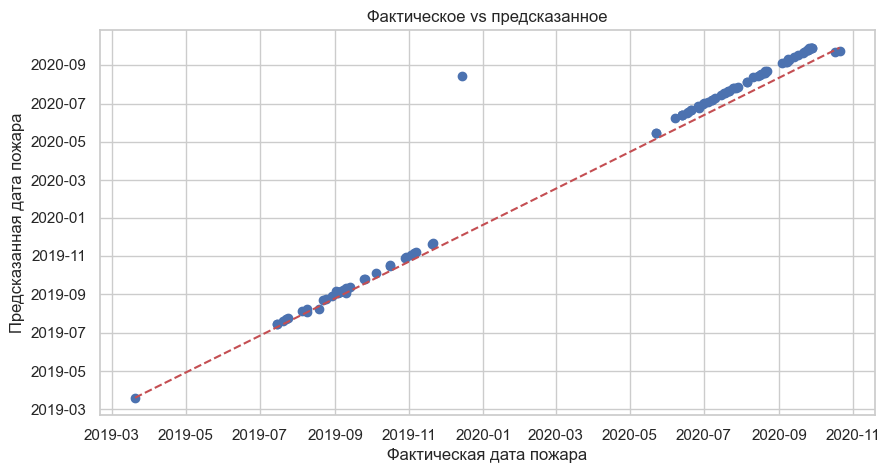

In [119]:
start_dates_test = df_model.loc[X_test.index, 'Нач.форм.штабеля']
start_dates_test = pd.to_datetime(start_dates_test, errors='coerce')
pred_fire_dates = start_dates_test + pd.to_timedelta(y_pred, unit='D')
test_fire_dates = start_dates_test + pd.to_timedelta(y_test, unit='D')

plt.figure(figsize=(10,5))
plt.scatter(pred_fire_dates, test_fire_dates)
plt.plot([pred_fire_dates.min(), pred_fire_dates.max()],
         [test_fire_dates.min(), test_fire_dates.max()], 'r--')
plt.xlabel("Фактическая дата пожара")
plt.ylabel("Предсказанная дата пожара")
plt.title("Фактическое vs предсказанное")
plt.show()
